# Comparing the explainability built-in in XGBoost with LIME

This Python notebook compares the built-in explainability feature of XGBoost with the one provided by [LIME](https://github.com/marcotcr/lime).
The dataset being used is the [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/Adult), which has a significant amount of instances and attributes and contains continuous as well as categorical attributes.

## Setup

### Imports

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelBinarizer, StandardScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
import xgboost.sklearn as xgb_sklearn
import lime.lime_tabular

### Initializations

In [39]:
np.random.seed(1)
%matplotlib inline

### Patch XGBoost tree visualization to include leaf index

In [40]:
def _parse_node_patched_with_leaf_index(graph, text):
    """parse dumped node"""
    match = xgb.plotting._NODEPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2), shape='circle')
        return node
    match = xgb.plotting._LEAFPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2) +
                   '\nleaf index: ' + node, shape='box')
        return node
    raise ValueError('Unable to parse node: {0}'.format(text))


old_parse_node = xgb.plotting._parse_node
xgb.plotting._parse_node = _parse_node_patched_with_leaf_index

## Import the dataset

In [41]:
column_names = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status", "Occupation",
                "Relationship", "Race", "Sex", "Capital_Gain", "Capital Loss", "Hours per week", "Country", "Label"]
# Note that in case of "Capital Gain", the label was changed to "Capital_Gain", which would otherwise trip the
# graphical tree generator of XGBoost, as 'Gain', 'Weight' & 'Frequency' have a special meaning
df = pd.read_csv('data/adult.data', names=column_names, index_col=False)

In [42]:
df

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital Loss,Hours per week,Country,Label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [43]:
# labels = LabelBinarizer().fit_transform(df.iloc[:, -1])
# categorical_features_idxs = [1, 3, 5, 6, 7, 8, 9, 13]

# categorical_names = {}
# for feature in categorical_features_idxs:
#     le = LabelEncoder()
#     le.fit(df.iloc[:, feature])
#     #df.iloc[:, feature] = le.transform(df.iloc[:, feature])
#     categorical_names[feature] = le.classes_


# one_hot_encoder = OneHotEncoder(categorical_features=categorical_features_idxs)
# X_train_input = df.iloc[:, 0:-1].values
# # one_hot_encoder.fit_transform(one_hot_encoder)

# from collections import defaultdict

# #print(df.iloc[:, :-1])
# data = X_train_input[0:2]
# print('original\n'+str(data))
# d = defaultdict(LabelEncoder)
# fit = df.apply(lambda x: d[x.name].fit_transform(x))
# print(fit[0:2])
# reverse_fit = fit.apply(lambda x: d[x.name].inverse_transform(x))
# print(reverse_fit[0:2])

### Map to processable features

In [44]:
from sklearn_pandas import DataFrameMapper, cross_val_score
label_binarizer = LabelBinarizer()
mapper = DataFrameMapper([
    (['Age'], StandardScaler()),
    ('Workclass', LabelEncoder()),
    (['fnlwgt'], StandardScaler()),
    ('Education', LabelEncoder()),
    (['Education-Num'], StandardScaler()),
    ('Marital Status', LabelEncoder()),
    ('Occupation', LabelEncoder()),
    ('Relationship', LabelEncoder()),
    ('Race', LabelEncoder()),
    ('Sex', LabelEncoder()),
    (['Capital_Gain'], StandardScaler()),
    (['Capital Loss'], StandardScaler()),
    (['Hours per week'], StandardScaler()),
    ('Country', LabelEncoder()),
    ('Label', label_binarizer)
],
    df_out=True
)
fitted_df = mapper.fit_transform(df)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Fit XGBoost classifier

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    fitted_df.iloc[:, :-1], fitted_df.iloc[:, -1], test_size=0.20)
bst = xgb.XGBClassifier(n_estimators=300, max_depth=5)
bst.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test.values, bst.predict(X_test.values))

0.87148779364348228

## Explain a specific instance

In [47]:
i = 1412
X_train.iloc[i, :]

Age                1.423610
Workclass          4.000000
fnlwgt             0.443566
Education         11.000000
Education-Num     -0.420060
Marital Status     2.000000
Occupation         1.000000
Relationship       0.000000
Race               4.000000
Sex                1.000000
Capital_Gain      -0.145920
Capital Loss      -0.216660
Hours per week     0.369519
Country           39.000000
Name: 246, dtype: float64

### LIME

In [48]:
categorical_features_idxs = [1, 3, 5, 6, 7, 8, 9, 13]
categorical_names = {}
for feature in categorical_features_idxs:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(df.iloc[:, feature])
    categorical_names[feature] = le.classes_

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,  # fitted_df.iloc[:,:-1].values.astype(float),
                                                   feature_names=['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num',
                                                                  'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
                                                                  'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'],
                                                   categorical_features=categorical_features_idxs,
                                                   categorical_names=categorical_names,
                                                   class_names=label_binarizer.classes_,
                                                   kernel_width=3, verbose=False)

In [49]:
# Custom predict function not necessary, as all date has been transformed already
# predict_fn = lambda x: bst.predict_proba(mapper.fit_transform(x)).astype(float)
exp = explainer.explain_instance(
    X_train.iloc[i, :].values, bst.predict_proba, num_features=4)
exp.show_in_notebook(show_all=False)

### XGBoost

#### Instance explanation

In [50]:
booster = bst.get_booster()
inst = np.array([X_train.iloc[i, :].values])
prediction = bst.predict(inst)
print(bst.predict(inst))
label_binarizer.classes_[int(prediction)]

[ 1.]


' >50K'

In [51]:
dtrain = xgb.DMatrix(np.array([X_train.iloc[i, :].values]))
print(booster.predict(dtrain))
print(booster.predict(dtrain, output_margin=True))
contribs = booster.predict(dtrain, pred_contribs=True)
print(contribs)
print("Sum of contributions {}".format(
    booster.predict(dtrain, pred_contribs=True).sum()))

bleh = zip(df.columns[:-1], contribs[0])
sorted(bleh, key=lambda x: abs(x[1]), reverse=True)

[ 0.55912364]
[ 0.23760611]
[[ 0.56285393  0.06103075  0.1621342   0.00259273 -0.36059847  0.37797219
  -0.0675962   0.51703531  0.0260041   0.08433086 -0.14017731 -0.05712687
   0.39134136  0.03170956 -1.35389948]]
Sum of contributions 0.23760664463043213


[('Age', 0.56285393),
 ('Relationship', 0.51703531),
 ('Hours per week', 0.39134136),
 ('Marital Status', 0.37797219),
 ('Education-Num', -0.36059847),
 ('fnlwgt', 0.1621342),
 ('Capital_Gain', -0.14017731),
 ('Sex', 0.084330857),
 ('Occupation', -0.067596197),
 ('Workclass', 0.061030753),
 ('Capital Loss', -0.057126872),
 ('Country', 0.031709559),
 ('Race', 0.026004098),
 ('Education', 0.0025927317)]

#### Model explanation

In [52]:
legend_text = """Instance:  {0}

{1}

Predicted leaf: {2}
""".format(i, X_train.iloc[i, :], booster.predict(dtrain, pred_leaf=True)[0][0])
legend_test = '''
Instance:  + str(i)
'''

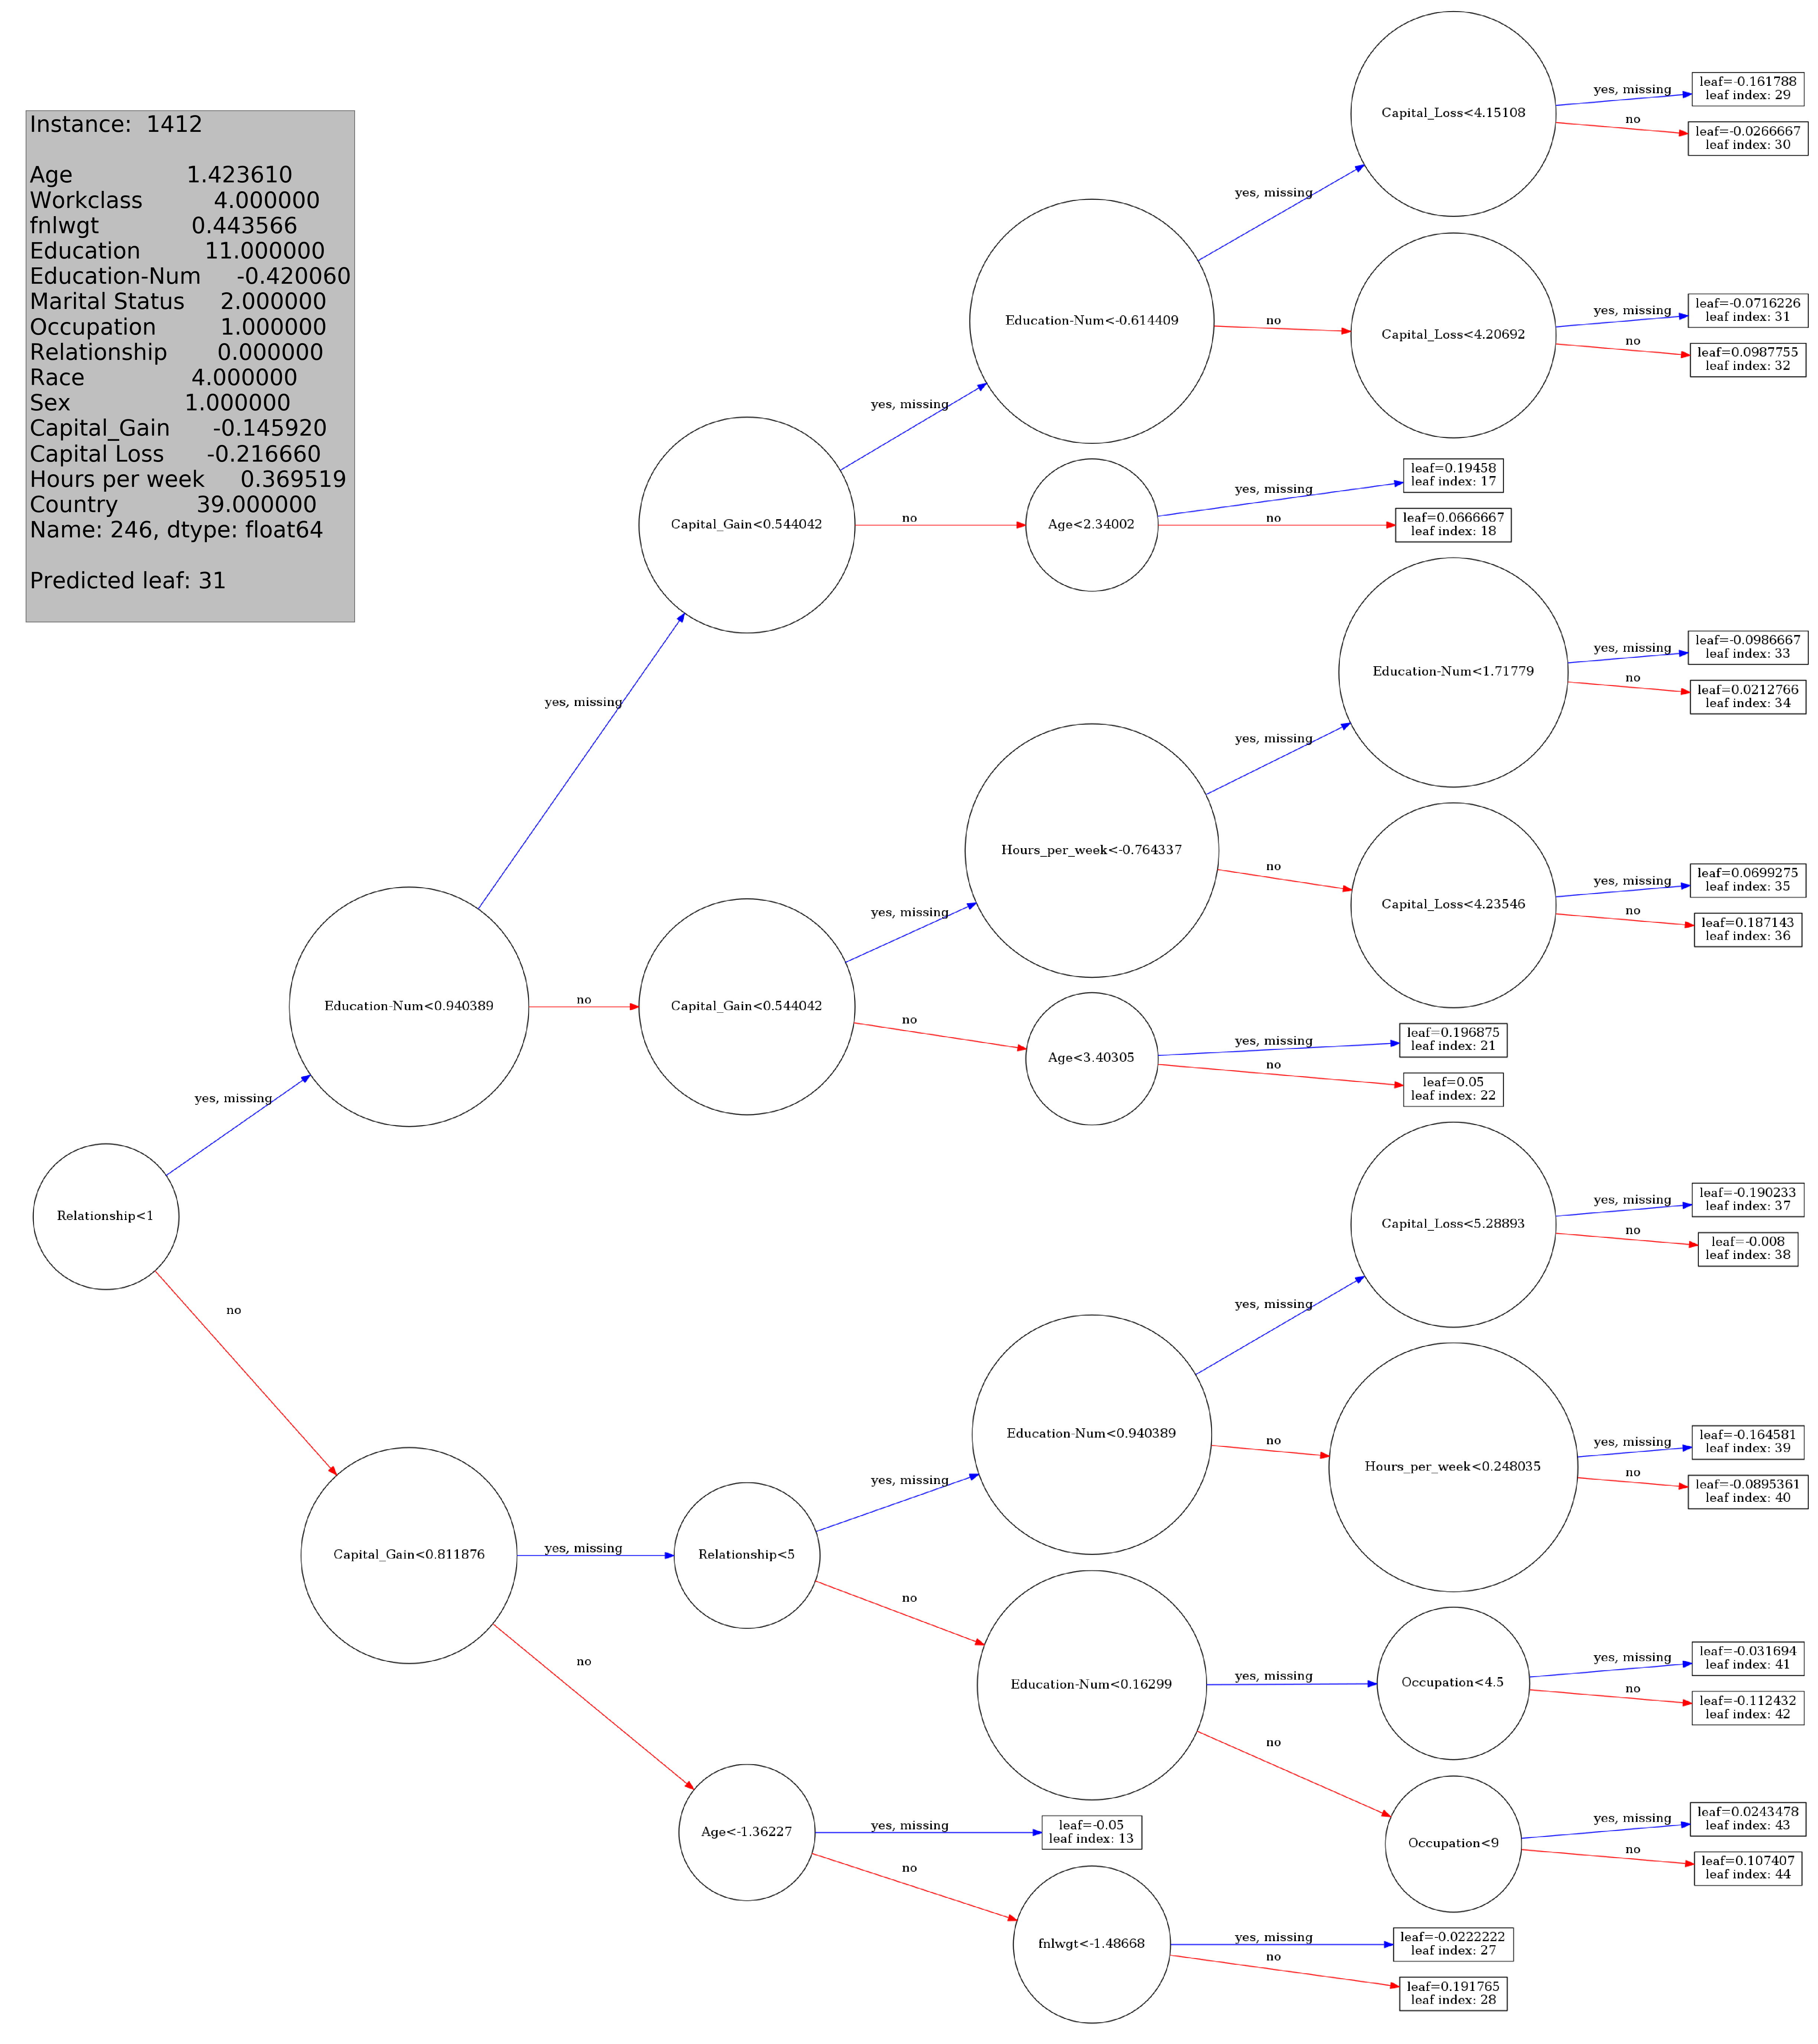

In [53]:
%config InlineBackend.figure_format = 'retina'
plt.rc('figure', figsize=(50, 50))
fig = plt.figure()
ax = fig.add_subplot(111)
xgb.plot_tree(bst, fmap='data/adult.fmap', num_trees=0, rankdir='LR', ax=ax)
ax.text(0.0, 0.7, legend_text, bbox={
        'facecolor': 'gray', 'alpha': 0.5, 'pad': 5}, fontsize=30, transform=ax.transAxes)
plt.show();

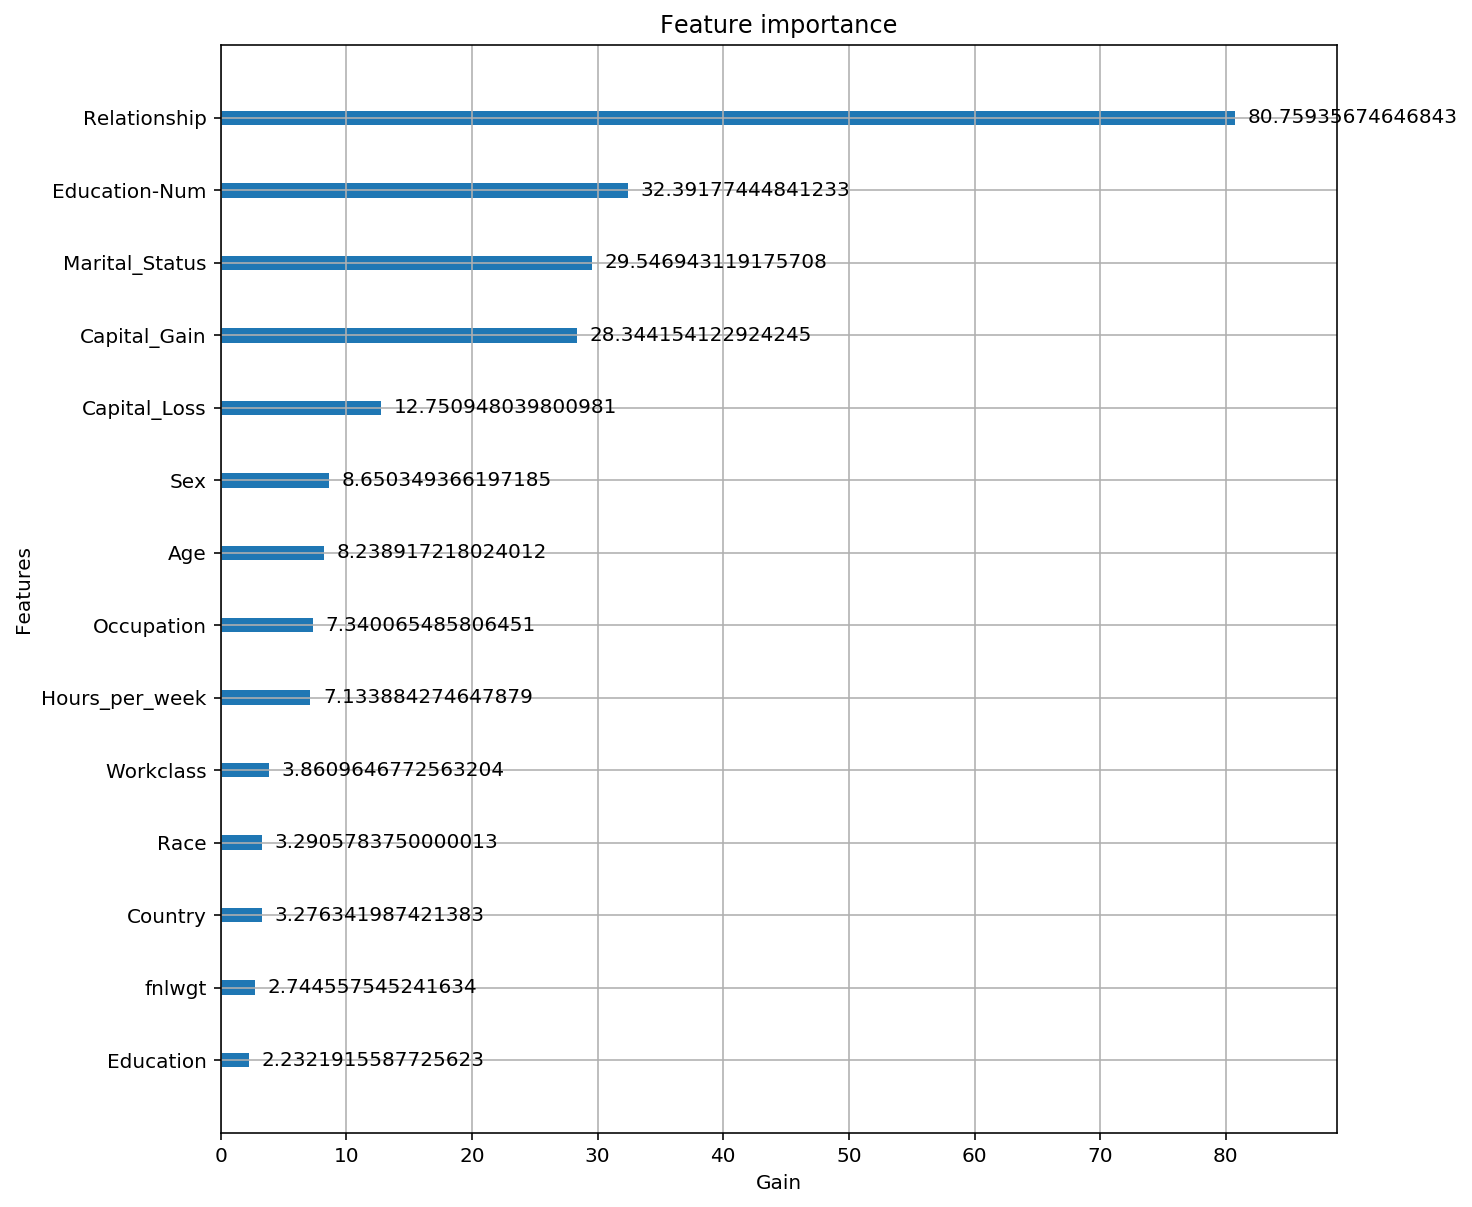

In [54]:
plt.rc('figure', figsize=(10, 10))
scores = booster.get_score(fmap='data/adult.fmap', importance_type='gain')
xgb.plot_importance(scores, xlabel='Gain')